# Data Pre-processing

Converting raw data into ingredients fit for our strategy recipe is an annoying yet necessary work. Here's how I cleaned and processed data for this project.

Ultimately, we want these data:

1. Industry Index Price Series (Quarterly)
2. Industry Index Total Return Series (Quarterly)
3. Industry Index Earnings Series (Quarterly)

In [2]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from datetime import datetime, timedelta
from xquant.util import *
import seaborn as sns

In [2]:
df_div = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/dividends.csv', parse_dates=['announced'], dtype={'ticker':str})
df_price = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/price.csv', index_col=['date'], parse_dates=['date'])
df_mktcap = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/market_cap.csv', index_col=['date'], parse_dates=['date'])
df_comp = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/WIND_index_comp.csv', parse_dates=['included', 'excluded'])
df_map = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/ticker_map.csv', index_col=['key'])
df_idx = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/WIND_industry_index.csv', index_col=['Date'], parse_dates=['Date'])

In [8]:
# time range for back test
START = datetime(2010,1,1)
END = datetime(2020,12,31)

## Clean dividend data

In [4]:
df_div['ticker'] = df_div['ticker'].apply(add_suffix) # convert ticker symbol into standard format (e.g. 000001.SZ)

In [5]:
df_div.dropna(subset=['announced'], inplace=True)

## Clean Index Members Data

In [6]:
# map symbols to actual names of industry
df_comp['industry'] = df_comp['industry'].apply(lambda x: df_map.at[x,'value'])

In [7]:
# if stock is still a member of the index, set excluded time to a future data far away
df_comp['excluded'].fillna(pd.Timestamp('20991231'), inplace=True)

In [8]:
df_comp.dropna(subset=['included'], inplace=True)

## Calculate Financial Metrics for an Index

Very often we would need to look at certain metrics of an index, such as earnings and dividends. In a market capitalization weighted indices with $n$ components, its metric $m$ is calculated by:

$\sum^{n}_{i=1} w_{i} \cdot m_{i}$

where $w$ is the weight of component $i$ in the index (i.e. market cap of component $i$ divided by sum of market cap for all components).

### First calculate the scale (i.e. multiplier) for each industry index at a certain date

In [9]:
def get_scale(date) -> dict:
    d = dict.fromkeys(df_idx.columns,[])
    for i in df_idx.columns:
        total = 0
        f = get_index_weights(df_mktcap, df_comp.query(f"industry=='{i}'"), pd.Timestamp(date))
        for s in f.index:
            local_sum = f[s] * df_price.at[pd.Timestamp(date), s]
            if pd.notna(local_sum):
                total += local_sum
        if total != 0:            
            d[i] = df_idx.at[date,i]/total
        else:
            d[i] = np.nan
    return d

### Then calculate the quarterly weighted sum of a metric

In [10]:
def get_weighted_sum_div(start, end, df, sum_col, date_col):
    begin = time.time()
    days = [closest_trading_day(day, df_price.index, 'bfill') for day in quarter_generator(start,end)]
    df_sum = pd.DataFrame(index=days, columns=df_idx.columns)

    for day in tqdm(df_sum.index):
        if day.quarter == 1:
            look_up = (day.year-1, 4)
        else:
            look_up = (day.year, day.quarter-1)

        scale_dict = get_scale(day)
        for industry in df_idx.columns:
            w = get_index_weights(df_mktcap, df_comp.query(f"industry=='{industry}'"), day)

            weighted = {}
            multiplier = scale_dict[industry]

            for stock in w.index:
                s = quarter_sum(ticker=stock, quarter=look_up, df=df, sum_col=sum_col, date_col=date_col)
                weighted_sum = w[stock] * s
                weighted[stock] = weighted_sum

            df_sum.at[day, industry] = pd.Series(weighted, dtype=float).sum() * multiplier
    
    print(f'\ncomputation completed in {time.time()-begin} seconds.')
    return df_sum

### Quarterly Dividends

In [11]:
df_div_q = get_weighted_sum_div(START, END, df_div, 'div_per_share', 'announced')

100%|██████████| 44/44 [08:04<00:00, 11.01s/it]
computation completed in 484.4346616268158 seconds.



In [12]:
df_div_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
2010-01-04,0,0,0.0218262,0,0,0,0.222113,0.00167726,0,0,NaN
2010-04-01,0,0.053968,0.0925406,0.0043455,0.0128965,0.273544,0.0181898,0.0900128,0,0.0312638,NaN
2010-07-01,13.4659,3.63686,1.1797,0.416404,4.17079,3.38796,9.37131,1.09074,7.03341,1.35964,NaN
2010-10-08,7.01905,0.346822,0.686881,0.223824,0.814055,0.758163,2.91279,0.126117,0,2.06145,NaN
2011-01-04,0,0.0349391,0.0760834,0.00520137,0.00242668,0.168036,0,0,0,0,NaN


In [13]:
df_div_q.to_csv('data\\quarterly_dividends.csv')

### Quarterly Prices

This one is easy, `xquant` has a function for exactly this.

In [14]:
df_idx_q = quarter_begin(df_idx, START, END)

In [15]:
df_idx_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
Date,,,,,,,,,,,
2010-01-04,4920.1377,3417.4678,2833.8413,3211.5559,3476.0491,3502.4775,2794.2654,1491.8711,3062.7134,2508.4985,2640.6350
2010-04-01,4302.1421,3289.4573,3000.3311,3245.0381,3454.6650,3716.7520,2712.7480,1634.3713,2777.5913,2543.8413,2682.0845
2010-07-01,2933.6196,2366.6641,2250.8965,2442.7336,2914.8982,3190.5137,2115.5417,1267.8278,2275.6130,1973.6053,1774.2311
2010-10-08,3497.7014,3275.6797,2866.8679,3259.8127,4090.4287,4380.9814,2194.1418,1610.4965,2286.0447,2224.2004,2081.5718
2011-01-04,3831.2097,3587.7126,3128.6135,3183.1685,4237.6450,4534.3213,2217.9629,1785.0106,2345.6482,2210.6975,2169.9316


In [16]:
df_idx_q.to_csv('data\\quarterly_prices.csv')

### Quarterly Total Return Series

Simply add the price series and dividend series together and normalize start date to 1.

In [17]:
df_total_rtn_q = df_idx_q + df_div_q.fillna(0)

In [18]:
df_total_rtn_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
Date,,,,,,,,,,,
2010-01-04,4920.137700,3417.467800,2833.863126,3211.555900,3476.049100,3502.477500,2794.487513,1491.872777,3062.713400,2508.498500,2640.6350
2010-04-01,4302.142100,3289.511268,3000.423641,3245.042445,3454.677896,3717.025544,2712.766190,1634.461313,2777.591300,2543.872564,2682.0845
2010-07-01,2947.085451,2370.300962,2252.076204,2443.150004,2919.068989,3193.901661,2124.913011,1268.918541,2282.646409,1974.964943,1774.2311
2010-10-08,3504.720452,3276.026522,2867.554781,3260.036524,4091.242755,4381.739563,2197.054594,1610.622617,2286.044700,2226.261847,2081.5718
2011-01-04,3831.209700,3587.747539,3128.689583,3183.173701,4237.647427,4534.489336,2217.962900,1785.010600,2345.648200,2210.697500,2169.9316


In [17]:
df_total_rtn_q.to_csv('data\\quarterly_total_returns.csv')

Might as well see what it looks like...

In [19]:
df_total_rtn_q = df_total_rtn_q.div(df_total_rtn_q.loc[df_total_rtn_q.index[0]]).mul(100)

<AxesSubplot:xlabel='Date'>

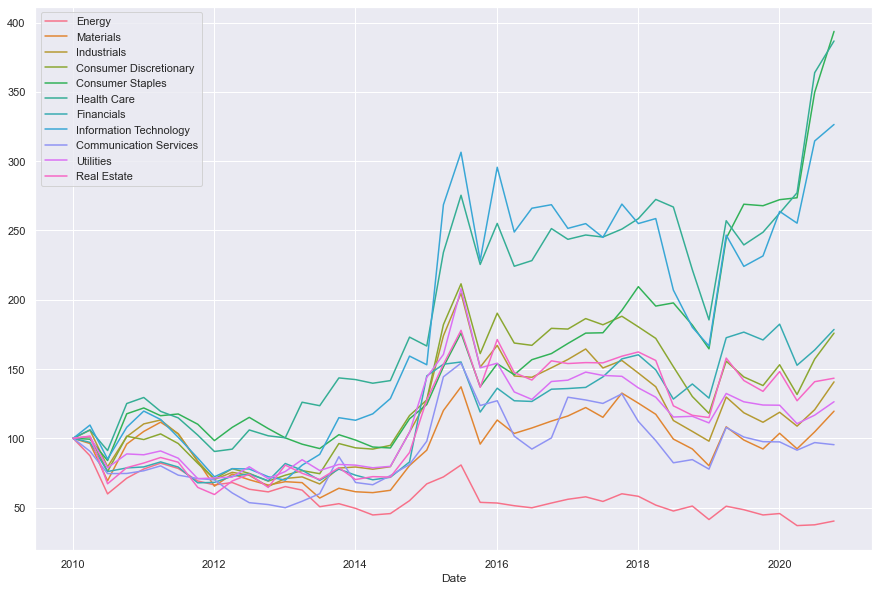

In [20]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(data=df_total_rtn_q, dashes=False)

### Quarterly Earnings Series

In [22]:
df_earnings = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/earnings.csv', parse_dates=['announced'], usecols=['ticker','announced','NPAP'])

In [23]:
df_earnings['ticker'] = df_earnings['ticker'].astype(str).apply(add_suffix)

Need to tweak `get_weighted_sum_div` a little bit.

In [24]:
def get_weighted_sum_earnings(start, end, df, sum_col, date_col):
    begin = time.time()
    days = [closest_trading_day(day, df_price.index, 'bfill') for day in quarter_generator(start,end)]
    df_sum = pd.DataFrame(index=days, columns=df_idx.columns)

    for day in tqdm(df_sum.index):
        if day.quarter == 1:
            look_up = (day.year-1, 4)
        else:
            look_up = (day.year, day.quarter-1)

        scale_dict = get_scale(day)
        for industry in df_idx.columns:
            w = get_index_weights(df_mktcap, df_comp.query(f"industry=='{industry}'"), day)

            weighted = {}
            multiplier = scale_dict[industry]

            for stock in w.index:
                try:
                    eps = get_eps(
                        ticker=stock, 
                        date=day, 
                        df_price=df_price, 
                        df_mktcap=df_mktcap, 
                        df_earnings=df_earnings, 
                        earnings_col='NPAP', 
                        date_col='announced')
                except IndexError:
                    eps = 0
                weighted_sum = w[stock] * eps
                weighted[stock] = weighted_sum

            df_sum.at[day, industry] = pd.Series(weighted, dtype=float).sum() * multiplier
    
    print(f'\ncomputation completed in {time.time()-begin} seconds.')
    return df_sum

In [25]:
df_earnings_q = get_weighted_sum_earnings(START, END, df_earnings, 'NPAP', 'announced')

100%|██████████| 44/44 [24:50<00:00, 33.88s/it]
computation completed in 1490.6374468803406 seconds.



In [26]:
df_earnings_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
2010-01-04,105.264,39.8356,42.2737,49.3541,72.346,88.2615,83.6761,11.3708,42.9106,64.9711,NaN
2010-04-01,107.138,53.8568,56.0926,48.188,83.2902,92.7987,110.553,15.3145,38.1387,70.8495,NaN
2010-07-01,28.7899,19.0292,16.909,14.6728,34.0273,25.8349,37.2438,4.07437,7.87208,15.2701,NaN
2010-10-08,58.5015,35.1445,40.7325,41.1083,62.3769,51.2823,68.5897,12.7997,14.3998,36.4203,NaN
2011-01-04,89.887,56.4413,70.166,58.0279,90.3213,78.2164,90.3066,20.981,20.5557,57.4827,NaN


### Finally, scale earnings

In [30]:
df_earnings_q = df_earnings_q * (df_total_rtn_q / df_prices_q)

## Adjusting for inflation

In [60]:
df_earnings_q = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/quarterly_earnings.csv', parse_dates=['Date'], index_col=['Date'])
df_total_returns_q = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/quarterly_prices.csv', parse_dates=['Date'], index_col=['Date'])
df_cpi = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/cpi.csv', parse_dates=['Date'], index_col=['Date'])

In [48]:
df_cpi = df_cpi.loc[START:END]
df_cpi = df_cpi / df_cpi['CPI'][0]
df_cpi.set_index(df_earnings_q.index, inplace=True)

In [49]:
df_cpi.head()

,CPI
Date,
2010-01-04,1.000000
2010-04-01,0.998641
2010-07-01,1.004269
2010-10-08,1.026536
2011-01-04,1.052236


In [56]:
for col in df_earnings_q.columns:
    df_earnings_q[col] = df_earnings_q[col] / df_cpi['CPI']
    df_total_returns_q[col] = df_total_returns_q[col] / df_cpi['CPI']

In [63]:
df_total_returns_q.to_csv('data\\quarterly_total_returns.csv')
df_earnings_q.to_csv('data\\quarterly_earnings.csv')